This report provides an analysis of transaction data and demographic data to recommend to predict total sales by liquor stores in Iowa. This information is then used to inform locational recommendations for building new liquor stores in Iowa. Data is sourced from the state of Iowa, and was grouped into store level data in order to infer about sales by store. The methods of analysis include multiple linear regression and scatterplot analysis. While initially examining the sales oriented data, the main focus of this study is on the demographic data. Locational data is likely to have correlation but not causation with sales, and for that reason the report analyzes the demographic data, or quantifiable population statistics that can be categorized by location, to infer about the ability of a location to predict sales. The hypothesis is that demographic data will help explain the variability of store sales. The results of the study unfortunately tell a different tale. Models including highly correlated sales variables, such as bottles sold, had high R^2 values (0.98), but models containing just the demographic data contained incredibly poor R^2 values. The conclusion is that demographic data at this level cannot reliably be used to predict store sales. As such the recommendation for new store locations was deferred to an analysis of the existing data outliers, and the assumption that these outliers will continue to outperform the rest of the data. Polk, Linn, and Scott counties were selected based on their relative outperformance in sales and undersaturation on a stores per county basis.
Limitations of the report include common survey biases that come from the demographic data. Further assessment should address intercounty data to find the least saturated points in these counties.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score, cross_val_predict
import statsmodels.api as sm

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df = pd.read_csv('~/Downloads/iowa_liquor_sales_proj_2.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
# load demographic data
dem_df = pd.read_csv('~/Downloads/iowa_proj_data.csv')

# drop missing and bad values
df.dropna(inplace=True)

# merge demographic data onto main df
df = df.merge(dem_df, how='left', on='County')

# df["Date"] = pd.to_datetime(df["Date"], format="%m-%d-%y")
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

### EDA ###

In [13]:
df.describe()

,Store Number,County Number,Category,Vendor Number,Item Number,Pack,Bottle Volume (ml),Bottles Sold,Volume Sold (Liters),Volume Sold (Gallons),Median Age,Population Over 21,Median Household Income,Avg Household Size,Homeowner Vacancy Rate,Unemployment Rate,Percent Bachelor's Degree +
count,2.692602e+06,2.692602e+06,2.692602e+06,2.692602e+06,2.692602e+06,2.692602e+06,2.692602e+06,2.692602e+06,2.692602e+06,2.692602e+06,2.692602e+06,2.692602e+06,2.692602e+06,2.692602e+06,2.692602e+06,2.692602e+06,2.692602e+06
mean,3.586458e+03,5.725644e+01,1.043815e+06,2.563220e+02,4.596171e+04,1.229845e+01,9.246156e+02,9.842646e+00,8.933294e+00,2.360130e+00,3.608041e+01,9.078255e+04,5.745347e+04,2.449014e+00,1.608280e+00,4.645174e+00,2.832776e-01
std,9.479188e+02,2.732611e+01,5.011081e+04,1.408340e+02,5.268866e+04,7.582892e+00,5.467320e+02,2.353895e+01,2.830157e+01,7.476472e+00,3.481209e+00,8.994169e+04,6.744569e+03,7.736129e-02,4.321345e-01,1.148564e+00,9.921934e-02
min,2.106000e+03,1.000000e+00,1.011100e+06,1.000000e+01,1.460000e+02,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.650000e+01,3.281000e+03,3.680800e+04,2.270000e+00,8.000000e-01,1.800000e+00,1.170000e-01
25%,2.604000e+03,3.100000e+01,1.012200e+06,1.150000e+02,2.682700e+04,6.000000e+00,7.500000e+02,2.000000e+00,1.500000e+00,4.000000e-01,3.440000e+01,1.560500e+04,5.187700e+04,2.410000e+00,1.500000e+00,4.000000e+00,2.050000e-01
50%,3.719000e+03,6.200000e+01,1.031200e+06,2.600000e+02,3.817600e+04,1.200000e+01,7.500000e+02,6.000000e+00,5.250000e+00,1.390000e+00,3.540000e+01,6.112600e+04,5.620800e+04,2.450000e+00,1.500000e+00,4.900000e+00,2.700000e-01
75%,4.378000e+03,7.700000e+01,1.062310e+06,3.800000e+02,6.460100e+04,1.200000e+01,1.000000e+03,1.200000e+01,1.050000e+01,2.770000e+00,3.870000e+01,1.342200e+05,6.416900e+04,2.490000e+00,1.700000e+00,5.200000e+00,3.560000e-01
max,9.023000e+03,9.900000e+01,1.701100e+06,9.780000e+02,9.992750e+05,3.360000e+02,2.250000e+05,3.960000e+03,3.960000e+03,1.046120e+03,4.330000e+01,2.633390e+05,8.212300e+04,2.710000e+00,3.700000e+00,8.400000e+00,5.240000e-01


In [14]:
df.dtypes

Invoice/Item Number                    object
Date                           datetime64[ns]
Store Number                            int64
Store Name                             object
Address                                object
City                                   object
Zip Code                               object
Store Location                         object
County Number                         float64
County                                 object
Category                              float64
Category Name                          object
Vendor Number                           int64
Vendor Name                            object
Item Number                             int64
Item Description                       object
Pack                                    int64
Bottle Volume (ml)                      int64
State Bottle Cost                      object
State Bottle Retail                    object
Bottles Sold                            int64
Sale (Dollars)                    

In [15]:
df.describe(include=['O'])

,Invoice/Item Number,Store Name,Address,City,Zip Code,Store Location,County,Category Name,Vendor Name,Item Description,State Bottle Cost,State Bottle Retail,Sale (Dollars)
count,2692602,2692602,2692602,2692602,2692602,2692602,2692602,2692602,2692602,2692602,2692602,2692602,2692602
unique,2692602,1374,1375,383,737,1719,99,73,158,2977,1459,1511,11402
top,S30168200156,Hy-Vee #3 / BDI / Des Moines,3221 SE 14TH ST,DES MOINES,50010,"3221 SE 14TH ST\nDES MOINES 50320\n(41.554101,...",Polk,VODKA 80 PROOF,Diageo Americas,Black Velvet,$8.25,$12.38,$162.00
freq,1,24167,31888,236776,68033,24167,490417,352213,466757,72161,60930,60930,34565


In [16]:
# drop '$' and convert to floats
df['State Bottle Cost'] = df['State Bottle Cost'].str.strip('$').astype(float)
df['State Bottle Retail'] = df['State Bottle Retail'].str.strip('$').astype(float)
df['Sale (Dollars)'] = df['Sale (Dollars)'].str.strip('$').astype(float)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2692602 entries, 6 to 2709551
Data columns (total 31 columns):
Invoice/Item Number            object
Date                           datetime64[ns]
Store Number                   int64
Store Name                     object
Address                        object
City                           object
Zip Code                       object
Store Location                 object
County Number                  float64
County                         object
Category                       float64
Category Name                  object
Vendor Number                  int64
Vendor Name                    object
Item Number                    int64
Item Description               object
Pack                           int64
Bottle Volume (ml)             int64
State Bottle Cost              float64
State Bottle Retail            float64
Bottles Sold                   int64
Sale (Dollars)                 float64
Volume Sold (Liters)           float64
Volum

In [18]:
# drop repetitive columns
df = df.drop(['City', 'Zip Code', 'County Number', 'Item Number', 'Volume Sold (Gallons)', 'Vendor Number', 'Category', ], axis='columns')

df.drop(['Invoice/Item Number', 'Date', 'Store Name', 'Address',
       'Store Location', 'Category Name', 'Vendor Name',
       'Item Description', 'Pack',], axis='columns', inplace=True)

In [23]:
# count number of stores per county
cdf = df.groupby('County').sum()

store_count = {}
for i in df['County']:
    if i in store_count.keys():
        store_count[i] +=1
    else:
        store_count.update({i:0})

In [24]:
# merge store_count onto county df
sc = pd.DataFrame.from_dict(store_count, orient='index')
sc.rename(columns={0 : "Store Count"}, inplace=True)
cdf = cdf.merge(sc, left_index=True, right_index=True)

# drop unnecessary columns
cdf.drop(['Store Number','Median Age', 'Population Over 21',
       'Median Household Income', 'Avg Household Size',
       'Homeowner Vacancy Rate', 'Unemployment Rate',
       "Percent Bachelor's Degree +"], axis='columns', inplace=True)
cdf = cdf.merge(dem_df, how='left', left_index=True, right_on='County')

In [26]:
# make a county reference by store
county_d = dict(zip(df['Store Number'], df['County']))
county_d1 = {}
for k,v in county_d.items():
    if k not in county_d1.keys():
        county_d1.update({k : v})
cod = pd.DataFrame.from_dict(county_d1, orient='index')
cod.rename(columns={0 : "County"}, inplace=True)

In [27]:
store_df = df.groupby('Store Number').sum()
store_df = store_df.merge(cod, how='left', left_index=True, right_index=True)

store_df.drop(['Median Age', 'Population Over 21',
       'Median Household Income', 'Avg Household Size',
       'Homeowner Vacancy Rate', 'Unemployment Rate',
       "Percent Bachelor's Degree +"], axis='columns', inplace=True)
store_df = store_df.merge(dem_df, how='left', on='County')

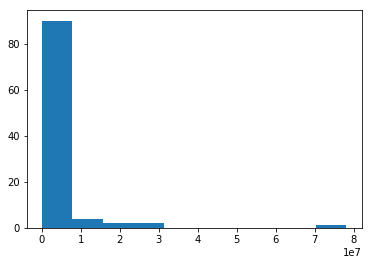

In [29]:
plt.hist(cdf['Sale (Dollars)']);

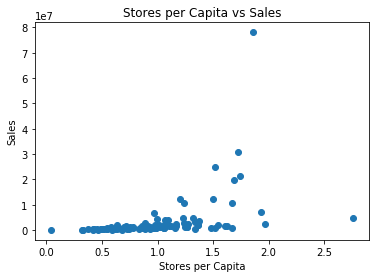

In [32]:
plt.scatter(cdf['Store Count'] / cdf['Population Over 21'], cdf['Sale (Dollars)'])
plt.title('Stores per Capita vs Sales')
plt.xlabel('Stores per Capita')
plt.ylabel('Sales');

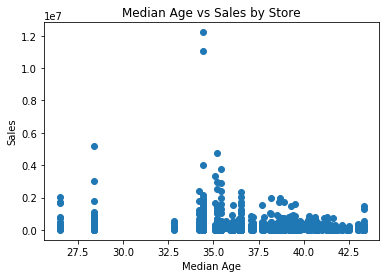

In [33]:
sd = store_df['Sale (Dollars)']
plt.scatter(store_df['Median Age'], sd)
plt.title('Median Age vs Sales by Store')
plt.xlabel('Median Age')
plt.ylabel('Sales');

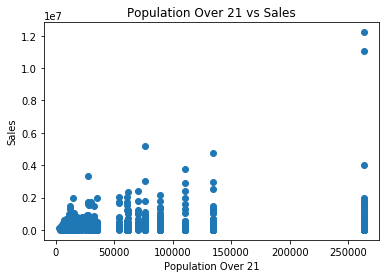

In [34]:
plt.scatter(store_df['Population Over 21'], sd)
plt.title('Population Over 21 vs Sales')
plt.xlabel('Population Over 21')
plt.ylabel('Sales');

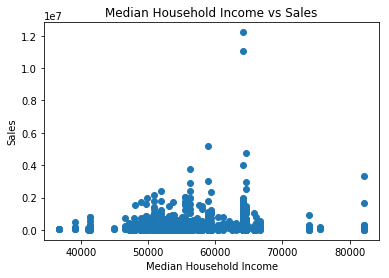

In [35]:
plt.scatter(store_df['Median Household Income'], sd)
plt.title('Median Household Income vs Sales')
plt.xlabel('Median Household Income')
plt.ylabel('Sales');

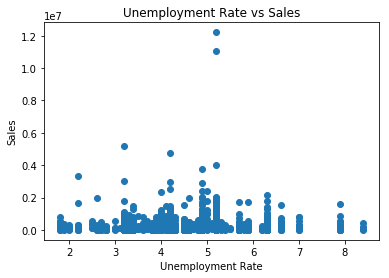

In [36]:
plt.scatter(store_df['Unemployment Rate'], sd)
plt.title('Unemployment Rate vs Sales')
plt.xlabel('Unemployment Rate')
plt.ylabel('Sales');

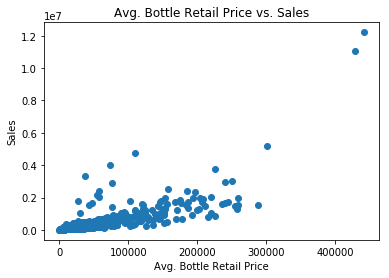

In [37]:
plt.scatter(store_df['State Bottle Retail'], sd)
plt.title('Avg. Bottle Retail Price vs. Sales')
plt.xlabel('Avg. Bottle Retail Price')
plt.ylabel('Sales');

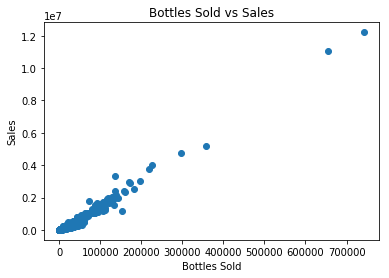

In [38]:
plt.scatter(store_df['Bottles Sold'], sd)
plt.title('Bottles Sold vs Sales')
plt.xlabel('Bottles Sold')
plt.ylabel('Sales');

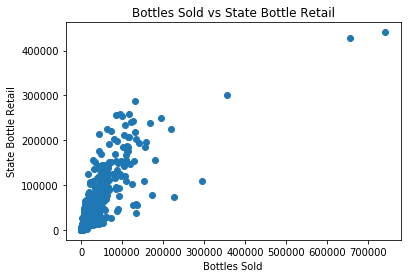

In [39]:
plt.scatter(store_df['Bottles Sold'], store_df['State Bottle Retail'])
plt.title('Bottles Sold vs State Bottle Retail')
plt.xlabel('Bottles Sold')
plt.ylabel('State Bottle Retail');

At the county level, total sales is skewed to the right by outliers. My initial reaction is that these merit further investigation because the owner wants to maximize sales. Bottles Sold appears to have the strongest correlation to total sales, and the fewest outliers from a linear perspective. The initial outlook on the demographic data is not encouraging.

In [40]:
cdf.corr()

,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Store Count,Median Age,Population Over 21,Median Household Income,Avg Household Size,Homeowner Vacancy Rate,Unemployment Rate,Percent Bachelor's Degree +
Bottle Volume (ml),1.000000,0.999542,0.999542,0.995683,0.994581,0.997232,0.999688,-0.484509,0.990212,0.222863,0.021572,-0.233629,0.128275,0.508417
State Bottle Cost,0.999542,1.000000,1.000000,0.996892,0.996558,0.998260,0.999443,-0.479080,0.988291,0.218450,0.018439,-0.222991,0.127932,0.505686
State Bottle Retail,0.999542,1.000000,1.000000,0.996890,0.996556,0.998259,0.999443,-0.479094,0.988291,0.218464,0.018437,-0.223001,0.127919,0.505706
Bottles Sold,0.995683,0.996892,0.996890,1.000000,0.998615,0.998847,0.996660,-0.458140,0.987836,0.215455,0.025060,-0.215010,0.128308,0.490634
Sale (Dollars),0.994581,0.996558,0.996556,0.998615,1.000000,0.999256,0.994863,-0.460342,0.984480,0.226371,0.025330,-0.204476,0.116674,0.502010
Volume Sold (Liters),0.997232,0.998260,0.998259,0.998847,0.999256,1.000000,0.997363,-0.466128,0.987855,0.228138,0.024170,-0.214811,0.118324,0.504393
Store Count,0.999688,0.999443,0.999443,0.996660,0.994863,0.997363,1.000000,-0.481168,0.990747,0.217926,0.022377,-0.230824,0.133090,0.502797
Median Age,-0.484509,-0.479080,-0.479094,-0.458140,-0.460342,-0.466128,-0.481168,1.000000,-0.527136,-0.388503,-0.476454,0.484238,-0.072195,-0.670125
Population Over 21,0.990212,0.988291,0.988291,0.987836,0.984480,0.987855,0.990747,-0.527136,1.000000,0.245688,0.082130,-0.272569,0.150942,0.519359
Median Household Income,0.222863,0.218450,0.218464,0.215455,0.226371,0.228138,0.217926,-0.388503,0.245688,1.000000,0.568468,-0.245146,-0.383310,0.520771


In [41]:
store_df.corr()

,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Median Age,Population Over 21,Median Household Income,Avg Household Size,Homeowner Vacancy Rate,Unemployment Rate,Percent Bachelor's Degree +
Bottle Volume (ml),1.000000,0.986833,0.986874,0.777469,0.741920,0.768185,-0.080487,0.072476,0.030607,-0.023779,-0.051076,0.017900,0.080739
State Bottle Cost,0.986833,1.000000,1.000000,0.807174,0.776787,0.789160,-0.106831,0.103345,0.044601,-0.023935,-0.056981,0.030776,0.108097
State Bottle Retail,0.986874,1.000000,1.000000,0.807087,0.776691,0.789089,-0.106809,0.103308,0.044598,-0.023944,-0.056970,0.030739,0.108082
Bottles Sold,0.777469,0.807174,0.807087,1.000000,0.986706,0.985931,-0.126592,0.143214,0.067893,-0.005389,-0.076785,0.049047,0.131674
Sale (Dollars),0.741920,0.776787,0.776691,0.986706,1.000000,0.993356,-0.109411,0.119986,0.069337,-0.003864,-0.052501,0.027825,0.120209
Volume Sold (Liters),0.768185,0.789160,0.789089,0.985931,0.993356,1.000000,-0.099286,0.107097,0.062150,-0.007909,-0.053739,0.023102,0.108687
Median Age,-0.080487,-0.106831,-0.106809,-0.126592,-0.109411,-0.099286,1.000000,-0.486330,-0.366636,-0.145892,0.422038,-0.122331,-0.839323
Population Over 21,0.072476,0.103345,0.103308,0.143214,0.119986,0.107097,-0.486330,1.000000,0.494548,0.015110,-0.295078,0.265007,0.556419
Median Household Income,0.030607,0.044601,0.044598,0.067893,0.069337,0.062150,-0.366636,0.494548,1.000000,0.395961,-0.139955,-0.316889,0.556174
Avg Household Size,-0.023779,-0.023935,-0.023944,-0.005389,-0.003864,-0.007909,-0.145892,0.015110,0.395961,1.000000,-0.368451,-0.072518,-0.129856


For individual transactions, bottle volume, bottles sold and volume sold have the strongest correlation, which is not suprising. It indicates that most transactions are for multiple bottles, else bottle retail price would have a higher correlation. At the zip code level, bottles sold and volume sold have the strongest correlation to total sales.

In [42]:
# store level model
y1 = store_df['Sale (Dollars)']
X1 = store_df.drop(['State Bottle Cost', 'Bottle Volume (ml)', 'County', 'Volume Sold (Liters)', 'Sale (Dollars)', 'State Bottle Retail'], axis='columns')
X1 = sm.add_constant(X1)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3)

model = sm.OLS(y1_train, X1_train)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Sale (Dollars)   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     4781.
Date:                Fri, 09 Feb 2018   Prob (F-statistic):               0.00
Time:                        02:43:15   Log-Likelihood:                -12403.
No. Observations:                 966   AIC:                         2.482e+04
Df Residuals:                     957   BIC:                         2.487e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                         1.49e+05   2.39e+05      0.625      0.532   -3.19e+05    6.17e+05
Bottles Sold                   15.4677      0.080    193.346      0.000      15.311      15.625
Median Age                  -3136.6192   2702.918     -1.160      0.246   -8440.950    2167.712
Population Over 21             -0.1296      0.050     -2.602      0.009      -0.227      -0.032
Median Household Income         0.8406      0.927      0.907      0.365      -0.978       2.660
Avg Household Size          -3.871e+04   6.96e+04     -0.556      0.578   -1.75e+05     9.8e+04
Homeowner Vacancy Rate       1.733e+04   8122.688      2.134      0.033    1392.970    3.33e+04
Unemployment Rate           -3092.6547   3247.101     -0.952      0.341   -9464.916    3279.606
Percent Bachelor's Degree + -1.348e+05   1.14e+05     -1.180      0.238   -3.59e+05    8.94e+04
==============================================================================
Omnibus:                      562.983   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            67593.330
Skew:                          -1.684   Prob(JB):                         0.00
Kurtosis:                      43.841   Cond. No.                     1.16e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
# store level model
lm = linear_model.LinearRegression()

y = store_df['Sale (Dollars)']
X = store_df.drop(['State Bottle Cost', 'Bottle Volume (ml)', 'County', 'Volume Sold (Liters)', 'Sale (Dollars)', 'State Bottle Retail'], axis='columns') 

X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.3)

model = lm.fit(X1_train, y1_train)
model.score(X1_test,y1_test)

0.95591498294008237

In [44]:
# No sales data
X2 = store_df.drop(['State Bottle Cost', 'Bottle Volume (ml)', 'County', 'Volume Sold (Liters)', 'Sale (Dollars)', 'State Bottle Retail', 'Bottles Sold'], axis='columns')
X2 = sm.add_constant(X2)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y1, test_size=0.3)

model2 = sm.OLS(y2_train, X2_train)
model2 = model2.fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Sale (Dollars)   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     3.017
Date:                Fri, 09 Feb 2018   Prob (F-statistic):            0.00385
Time:                        02:43:23   Log-Likelihood:                -13866.
No. Observations:                 966   AIC:                         2.775e+04
Df Residuals:                     958   BIC:                         2.779e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                       -3.427e+05   1.06e+06     -0.323      0.747   -2.42e+06    1.74e+06
Median Age                   4525.0979   1.21e+04      0.374      0.708   -1.92e+04    2.83e+04
Population Over 21              0.0955      0.226      0.422      0.673      -0.349       0.539
Median Household Income        -1.4264      4.245     -0.336      0.737      -9.756       6.904
Avg Household Size           9.558e+04    3.1e+05      0.309      0.758   -5.12e+05    7.03e+05
Homeowner Vacancy Rate       1684.9502   3.79e+04      0.044      0.965   -7.27e+04    7.61e+04
Unemployment Rate            6891.1482   1.48e+04      0.465      0.642   -2.22e+04     3.6e+04
Percent Bachelor's Degree +   7.88e+05   5.14e+05      1.532      0.126   -2.21e+05     1.8e+06
==============================================================================
Omnibus:                     1007.373   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            58834.374
Skew:                           4.954   Prob(JB):                         0.00
Kurtosis:                      39.926   Cond. No.                     1.10e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
lm = linear_model.LinearRegression()

y = store_df['Sale (Dollars)']
X = store_df.drop(['State Bottle Cost', 'Bottle Volume (ml)', 'County', 'Volume Sold (Liters)', 'Sale (Dollars)', 'State Bottle Retail', 'Bottles Sold'], axis='columns')

X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size=0.3)

model = lm.fit(X2_train, y2_train)
model.score(X2_test,y2_test)

0.01641427267698603

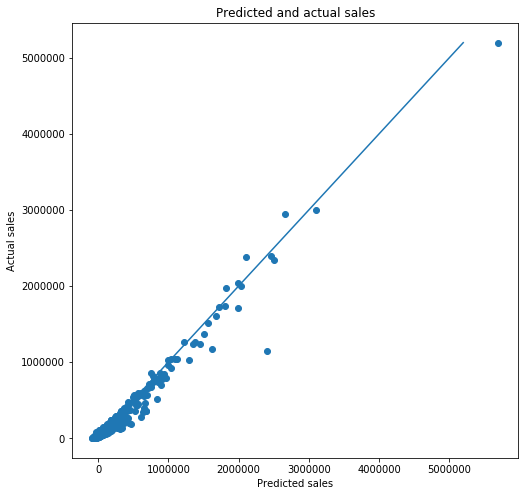

In [48]:
predictions = model.predict(X1_test)
fig, ax = plt.subplots(figsize=(8,8))
plt.scatter(predictions, y1_test)
plt.plot([min(y1_test), max(y1_test)], [min(y1_test), max(y1_test)], '-')
plt.title('Predicted and actual sales')
plt.xlabel('Predicted sales')
plt.ylabel('Actual sales');

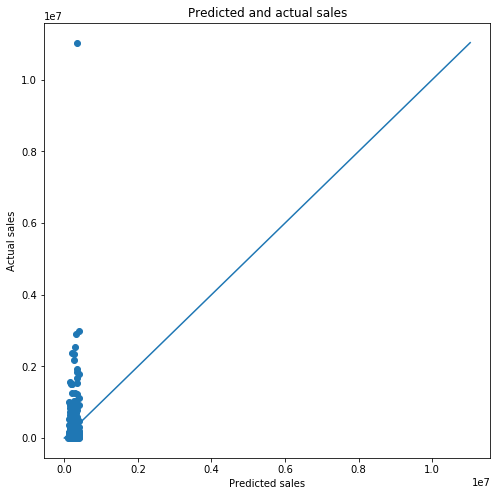

In [50]:
predictions = model.predict(X2_test)
fig, ax = plt.subplots(figsize=(8,8))
plt.scatter(predictions, y2_test)
plt.plot([min(y2_test), max(y2_test)], [min(y2_test), max(y2_test)], '-')
plt.title('Predicted and actual sales')
plt.xlabel('Predicted sales')
plt.ylabel('Actual sales');

In [52]:
store_df = store_df.reset_index()
top_list = store_df.groupby(['County']).max()

winners = store_df[store_df['Sale (Dollars)'].isin(top_list['Sale (Dollars)'])]
winners.sort_values('Sale (Dollars)', ascending=False).drop(['Median Age', 'Population Over 21',
                                                             'Median Household Income', 'Avg Household Size',
                                                             'Homeowner Vacancy Rate', 'Unemployment Rate',
                                                             "Percent Bachelor's Degree +"], axis='columns')

,index,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),County
125,125,22186100,293819.00,441031.36,742129,12214189.96,726516.61,Polk
36,36,16613575,200310.31,300716.72,356452,5196532.16,337260.18,Johnson
194,194,6505300,73197.26,109882.97,296076,4749484.91,330018.70,Linn
389,389,10288028,150340.69,225596.51,219554,3754411.18,209791.80,Scott
323,323,1556300,24789.12,37197.81,135035,3347853.91,169558.80,Dallas
204,204,3625050,38265.56,57438.90,134392,2376427.18,161434.75,Woodbury
499,499,10413825,130507.13,195857.08,159632,2335218.17,139117.18,Dubuque
212,212,3631050,36377.81,54619.21,137677,2182944.88,162130.45,Black Hawk
216,216,3543800,37783.77,56730.90,127772,2043493.33,155049.25,Story
123,123,12325962,145874.32,219002.55,130432,2004145.50,124432.38,Pottawattamie
